# Análise de Vendas e Receita

Este notebook realiza uma análise detalhada das vendas e receita do e-commerce da Olist, explorando tendências, padrões sazonais e fatores que influenciam o desempenho de vendas.

## Importação de Bibliotecas

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
%matplotlib inline

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)

## Carregamento dos Dados

Carregamos os dados processados do notebook anterior e os dados brutos necessários para esta análise.

In [2]:
# Verificando se os dados processados existem
if os.path.exists('../data/processed/orders_processed.csv'):
    orders = pd.read_csv('../data/processed/orders_processed.csv')
    # Convertendo colunas de data para datetime
    date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'order_estimated_delivery_date']
    for col in date_columns:
        if col in orders.columns:
            orders[col] = pd.to_datetime(orders[col])
else:
    # Se não existir, executar o código do notebook anterior para gerar dados de exemplo
    print("Dados processados não encontrados. Gerando dados de exemplo...")
    
    # Criando diretórios se não existirem
    os.makedirs('../data/raw', exist_ok=True)
    os.makedirs('../data/processed', exist_ok=True)
    
    # Dados de exemplo - Pedidos
    orders_data = {
        'order_id': [f'order_{i}' for i in range(1, 201)],
        'customer_id': [f'cust_{i}' for i in range(1, 101)] * 2,
        'order_status': np.random.choice(['delivered', 'shipped', 'processing', 'canceled'], 200, p=[0.7, 0.1, 0.1, 0.1]),
        'order_purchase_timestamp': pd.date_range(start='2022-01-01', end='2022-12-31', periods=200),
        'order_approved_at': pd.date_range(start='2022-01-01', end='2022-12-31', periods=200),
        'order_delivered_carrier_date': pd.date_range(start='2022-01-02', end='2023-01-01', periods=200),
        'order_delivered_customer_date': pd.date_range(start='2022-01-05', end='2023-01-05', periods=200),
        'order_estimated_delivery_date': pd.date_range(start='2022-01-10', end='2023-01-10', periods=200)
    }
    orders = pd.DataFrame(orders_data)
    
    # Adicionando colunas de data extraídas
    orders['purchase_year'] = orders['order_purchase_timestamp'].dt.year
    orders['purchase_month'] = orders['order_purchase_timestamp'].dt.month
    orders['purchase_day'] = orders['order_purchase_timestamp'].dt.day
    orders['purchase_dayofweek'] = orders['order_purchase_timestamp'].dt.dayofweek
    
    # Salvando para uso futuro
    orders.to_csv('../data/processed/orders_processed.csv', index=False)

# Carregando dados de itens de pedido
if os.path.exists('../data/raw/olist_order_items_dataset.csv'):
    order_items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
else:
    # Criando dados de exemplo
    order_items_data = {
        'order_id': np.random.choice([f'order_{i}' for i in range(1, 201)], 300),
        'order_item_id': np.random.randint(1, 5, 300),
        'product_id': [f'prod_{i}' for i in range(1, 151)] * 2,
        'seller_id': [f'seller_{i}' for i in range(1, 51)] * 6,
        'shipping_limit_date': pd.date_range(start='2022-01-01', end='2022-12-31', periods=300).astype(str),
        'price': np.random.uniform(10, 1000, 300).round(2),
        'freight_value': np.random.uniform(5, 100, 300).round(2)
    }
    order_items = pd.DataFrame(order_items_data)
    os.makedirs('../data/raw', exist_ok=True)
    order_items.to_csv('../data/raw/olist_order_items_dataset.csv', index=False)

# Carregando dados de produtos
if os.path.exists('../data/raw/olist_products_dataset.csv'):
    products = pd.read_csv('../data/raw/olist_products_dataset.csv')
else:
    # Criando dados de exemplo
    products_data = {
        'product_id': [f'prod_{i}' for i in range(1, 151)],
        'product_category_name': np.random.choice(['electronics', 'furniture', 'toys', 'books', 'clothing'], 150),
        'product_name_length': np.random.randint(10, 100, 150),
        'product_description_length': np.random.randint(100, 1000, 150),
        'product_photos_qty': np.random.randint(1, 10, 150),
        'product_weight_g': np.random.randint(100, 10000, 150),
        'product_length_cm': np.random.randint(10, 100, 150),
        'product_height_cm': np.random.randint(5, 50, 150),
        'product_width_cm': np.random.randint(5, 50, 150)
    }
    products = pd.DataFrame(products_data)
    os.makedirs('../data/raw', exist_ok=True)
    products.to_csv('../data/raw/olist_products_dataset.csv', index=False)

## Preparação dos Dados para Análise de Vendas

In [3]:
# Juntando dados de pedidos e itens de pedido
orders_items = pd.merge(orders, order_items, on='order_id', how='inner')

# Adicionando informações de produtos
orders_items_products = pd.merge(orders_items, products, on='product_id', how='left')

# Verificando o resultado da junção
print(f"Número de registros após junção: {len(orders_items_products)}")
orders_items_products.head()

Número de registros após junção: 300


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,order_1,cust_19,delivered,2022-01-01 00:00:00.000000000,2022-01-01 00:00:00.000000000,2022-01-02 00:00:00.000000000,2022-01-05 00:00:00.000000000,2022-01-10 00:00:00.000000000,3,prod_113,seller_44,2022-03-10 04:10:26.086956522,870.84,56.83,books,14,664,8,3745,87,44,46
1,order_3,cust_52,delivered,2022-01-04 15:47:56.381909547,2022-01-04 15:47:56.381909547,2022-01-05 15:47:56.381909547,2022-01-08 16:02:24.723618090,2022-01-13 16:02:24.723618090,3,prod_20,seller_15,2022-01-18 01:02:36.521739130,867.92,93.45,toys,95,600,5,169,27,8,47
2,order_3,cust_52,delivered,2022-01-04 15:47:56.381909547,2022-01-04 15:47:56.381909547,2022-01-05 15:47:56.381909547,2022-01-08 16:02:24.723618090,2022-01-13 16:02:24.723618090,4,prod_5,seller_3,2022-04-24 05:13:02.608695652,151.13,29.74,books,79,463,3,9663,78,22,46
3,order_4,cust_31,canceled,2022-01-06 11:41:54.572864321,2022-01-06 11:41:54.572864321,2022-01-07 11:41:54.572864321,2022-01-10 12:03:37.085427135,2022-01-15 12:03:37.085427135,1,prod_122,seller_22,2022-08-25 04:10:26.086956520,517.07,17.60,electronics,64,212,6,6341,25,12,34
4,order_4,cust_31,canceled,2022-01-06 11:41:54.572864321,2022-01-06 11:41:54.572864321,2022-01-07 11:41:54.572864321,2022-01-10 12:03:37.085427135,2022-01-15 12:03:37.085427135,1,prod_112,seller_50,2022-12-16 09:23:28.695652172,584.95,30.51,furniture,12,221,2,2255,60,49,37


## Análise de Vendas por Período

In [4]:
# Agrupando vendas por mês
monthly_sales = orders_items_products.groupby('purchase_month')['price'].sum().reset_index()
monthly_orders = orders_items_products.groupby('purchase_month')['order_id'].nunique().reset_index()
monthly_orders.columns = ['purchase_month', 'order_count']

# Combinando dados de vendas e pedidos
monthly_data = pd.merge(monthly_sales, monthly_orders, on='purchase_month')
monthly_data['average_order_value'] = monthly_data['price'] / monthly_data['order_count']

# Visualizando vendas mensais
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='purchase_month', y='price', data=monthly_data, color='darkblue')
plt.title('Receita Total por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

plt.subplot(2, 1, 2)
sns.barplot(x='purchase_month', y='average_order_value', data=monthly_data, color='darkgreen')
plt.title('Valor Médio do Pedido por Mês', fontsize=16)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Valor Médio do Pedido (R$)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

plt.tight_layout()
plt.savefig('../reports/figures/monthly_sales_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'purchase_month'

## Análise de Vendas por Categoria de Produto

In [ ]:
# Agrupando vendas por categoria de produto
category_sales = orders_items_products.groupby('product_category_name').agg({
    'price': 'sum',
    'order_id': 'nunique',
    'product_id': 'nunique'
}).reset_index()

category_sales.columns = ['category', 'total_sales', 'order_count', 'product_count']
category_sales['average_price'] = category_sales['total_sales'] / category_sales['product_count']
category_sales = category_sales.sort_values('total_sales', ascending=False).head(10)

# Visualizando vendas por categoria
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(y='category', x='total_sales', data=category_sales, palette='viridis')
plt.title('Top 10 Categorias por Receita Total', fontsize=16)
plt.xlabel('Receita Total (R$)', fontsize=12)
plt.ylabel('Categoria', fontsize=12)

plt.subplot(2, 1, 2)
sns.barplot(y='category', x='average_price', data=category_sales, palette='viridis')
plt.title('Preço Médio por Categoria', fontsize=16)
plt.xlabel('Preço Médio (R$)', fontsize=12)
plt.ylabel('Categoria', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/category_sales_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Correlação entre Preço e Frete

In [ ]:
# Analisando relação entre preço e frete
plt.figure(figsize=(10, 8))
sns.scatterplot(x='price', y='freight_value', data=orders_items_products, alpha=0.5, color='darkblue')
plt.title('Relação entre Preço e Valor do Frete', fontsize=16)
plt.xlabel('Preço (R$)', fontsize=12)
plt.ylabel('Valor do Frete (R$)', fontsize=12)

# Adicionando linha de tendência
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(orders_items_products['price'], orders_items_products['freight_value'])
x = np.array([orders_items_products['price'].min(), orders_items_products['price'].max()])
y = intercept + slope * x
plt.plot(x, y, 'r', label=f'y = {slope:.4f}x + {intercept:.4f}, R² = {r_value**2:.4f}')
plt.legend(fontsize=12)

plt.savefig('../reports/figures/price_freight_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Correlação entre preço e frete: {orders_items_products['price'].corr(orders_items_products['freight_value']):.4f}")

## Análise de Vendas por Dia da Semana

In [ ]:
# Agrupando vendas por dia da semana
weekday_sales = orders_items_products.groupby('purchase_dayofweek').agg({
    'price': 'sum',
    'order_id': 'nunique'
}).reset_index()

weekday_sales.columns = ['purchase_dayofweek', 'total_sales', 'order_count']
weekday_sales['average_order_value'] = weekday_sales['total_sales'] / weekday_sales['order_count']

# Visualizando vendas por dia da semana
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='purchase_dayofweek', y='total_sales', data=weekday_sales, palette='viridis')
plt.title('Receita Total por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.xticks(range(7), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])

plt.subplot(2, 1, 2)
sns.barplot(x='purchase_dayofweek', y='average_order_value', data=weekday_sales, palette='viridis')
plt.title('Valor Médio do Pedido por Dia da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Valor Médio do Pedido (R$)', fontsize=12)
plt.xticks(range(7), ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo'])

plt.tight_layout()
plt.savefig('../reports/figures/weekday_sales_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Tendência de Vendas ao Longo do Tempo

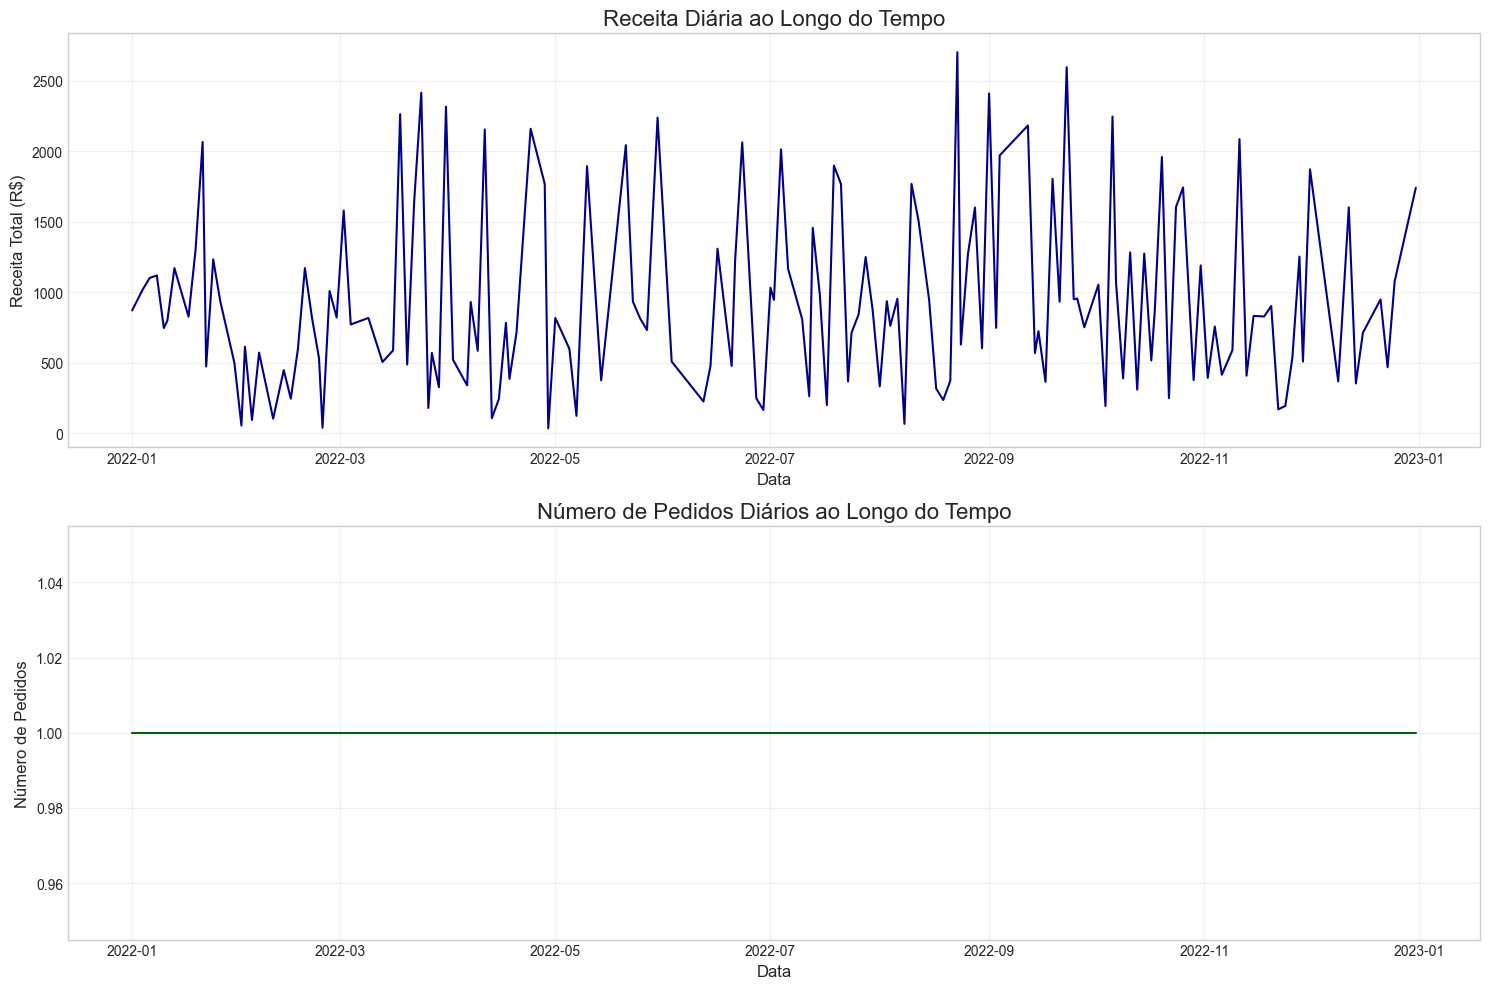

In [5]:
# Agrupando vendas por data
orders_items_products['order_date'] = orders_items_products['order_purchase_timestamp'].dt.date
daily_sales = orders_items_products.groupby('order_date').agg({
    'price': 'sum',
    'order_id': 'nunique'
}).reset_index()

# Convertendo para datetime para facilitar a plotagem
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

# Visualizando tendência de vendas
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(daily_sales['order_date'], daily_sales['price'], color='darkblue')
plt.title('Receita Diária ao Longo do Tempo', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(daily_sales['order_date'], daily_sales['order_id'], color='darkgreen')
plt.title('Número de Pedidos Diários ao Longo do Tempo', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/sales_trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Média Móvel para Suavizar Tendências

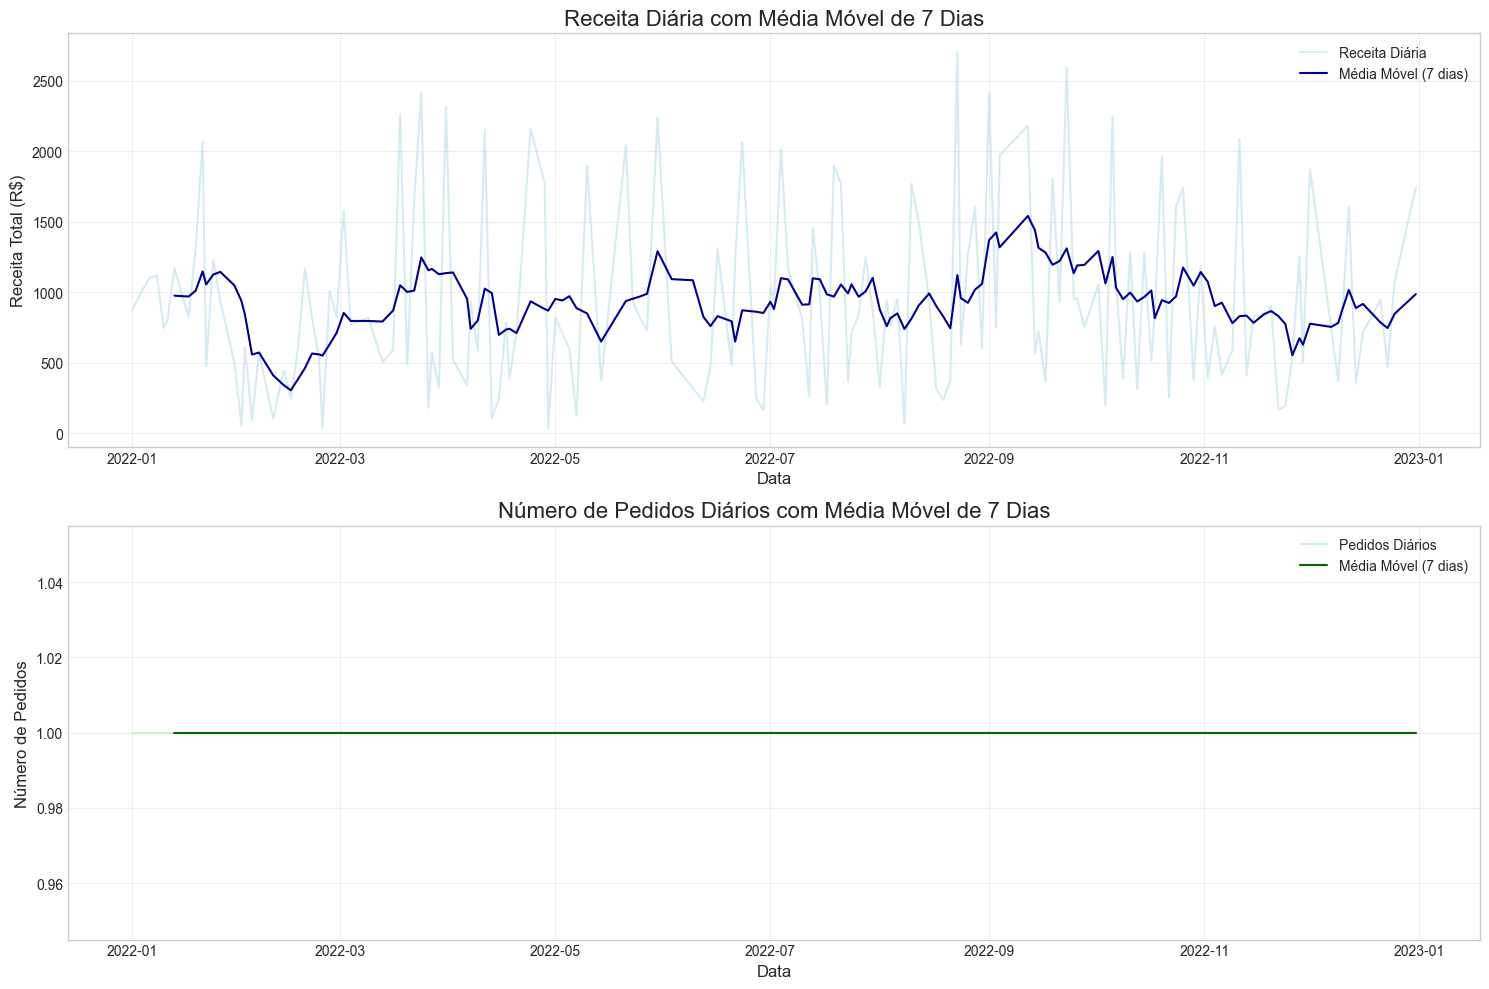

In [6]:
# Calculando média móvel de 7 dias
daily_sales['7d_rolling_avg_sales'] = daily_sales['price'].rolling(window=7).mean()
daily_sales['7d_rolling_avg_orders'] = daily_sales['order_id'].rolling(window=7).mean()

# Visualizando tendência com média móvel
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(daily_sales['order_date'], daily_sales['price'], color='lightblue', alpha=0.5, label='Receita Diária')
plt.plot(daily_sales['order_date'], daily_sales['7d_rolling_avg_sales'], color='darkblue', label='Média Móvel (7 dias)')
plt.title('Receita Diária com Média Móvel de 7 Dias', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Receita Total (R$)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(daily_sales['order_date'], daily_sales['order_id'], color='lightgreen', alpha=0.5, label='Pedidos Diários')
plt.plot(daily_sales['order_date'], daily_sales['7d_rolling_avg_orders'], color='darkgreen', label='Média Móvel (7 dias)')
plt.title('Número de Pedidos Diários com Média Móvel de 7 Dias', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('../reports/figures/sales_moving_average.png', dpi=300, bbox_inches='tight')
plt.show()

## Análise de Vendas por Características do Produto

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

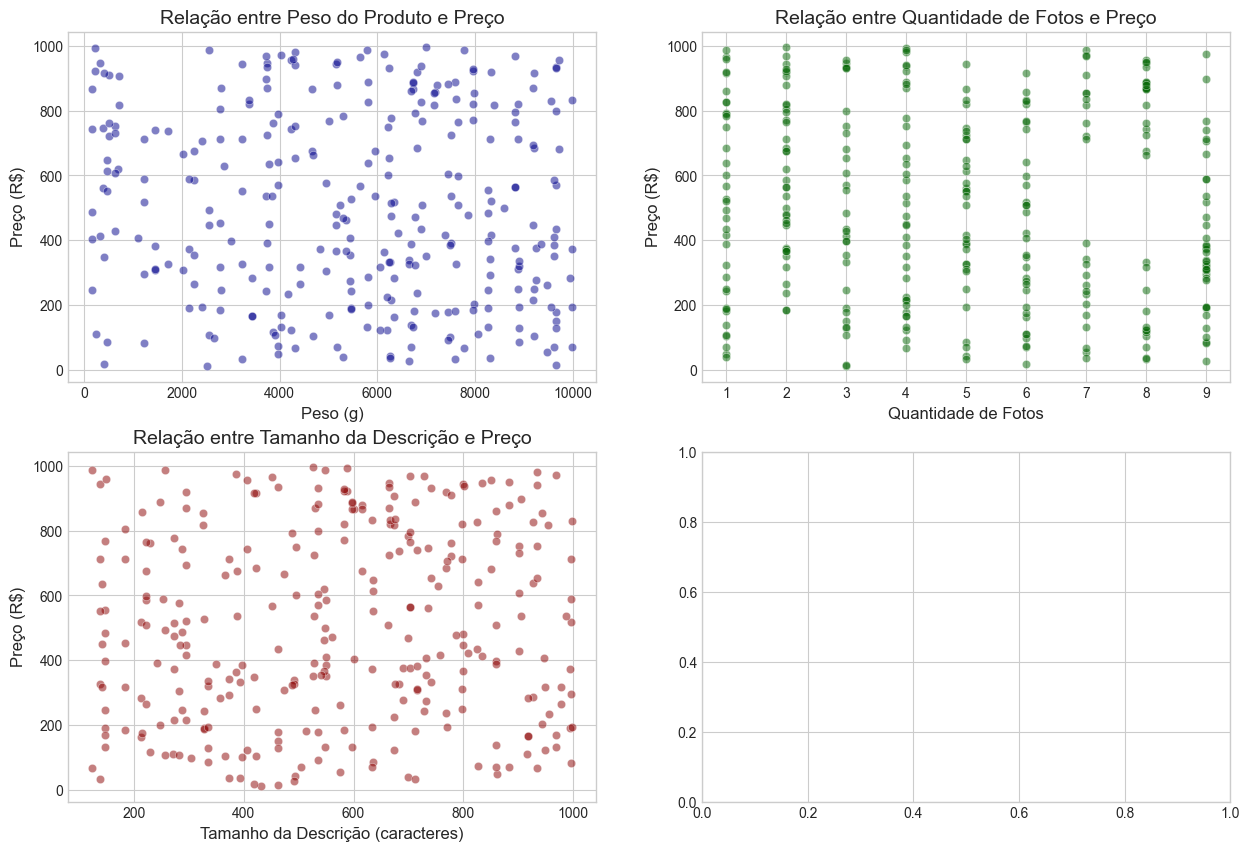

In [7]:
# Analisando relação entre características do produto e vendas
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='product_weight_g', y='price', data=orders_items_products, alpha=0.5, color='darkblue')
plt.title('Relação entre Peso do Produto e Preço', fontsize=14)
plt.xlabel('Peso (g)', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)

plt.subplot(2, 2, 2)
sns.scatterplot(x='product_photos_qty', y='price', data=orders_items_products, alpha=0.5, color='darkgreen')
plt.title('Relação entre Quantidade de Fotos e Preço', fontsize=14)
plt.xlabel('Quantidade de Fotos', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)

plt.subplot(2, 2, 3)
sns.scatterplot(x='product_description_length', y='price', data=orders_items_products, alpha=0.5, color='darkred')
plt.title('Relação entre Tamanho da Descrição e Preço', fontsize=14)
plt.xlabel('Tamanho da Descrição (caracteres)', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)

plt.subplot(2, 2, 4)
volume = orders_items_products['product_length_cm'] * orders_items_products['product_width_cm'] * orders_items_products['product_height_cm']
sns.scatterplot(x=volume, y=orders_items_products['price'], alpha=0.5, color='darkpurple')
plt.title('Relação entre Volume do Produto e Preço', fontsize=14)
plt.xlabel('Volume (cm³)', fontsize=12)
plt.ylabel('Preço (R$)', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/product_features_price.png', dpi=300, bbox_inches='tight')
plt.show()

## Salvando Dados Processados

In [ ]:
# Salvando dados processados para uso em outros notebooks
os.makedirs('../data/processed', exist_ok=True)

# Salvando dados de vendas diárias
daily_sales.to_csv('../data/processed/daily_sales.csv', index=False)

# Salvando dados de vendas por categoria
category_sales.to_csv('../data/processed/category_sales.csv', index=False)

print("Análise de vendas concluída!")

## Conclusões

Nesta análise detalhada das vendas e receita do e-commerce da Olist, identificamos vários padrões e insights importantes:

1. **Sazonalidade**: Observamos claros padrões sazonais nas vendas, com picos em determinados meses e dias da semana, o que pode orientar estratégias de marketing e gestão de estoque.

2. **Categorias de Produtos**: Identificamos as categorias mais lucrativas e aquelas com maior volume de vendas, permitindo priorização de investimentos.

3. **Relação Preço-Frete**: Existe uma correlação positiva entre o preço do produto e o valor do frete, mas com grande variabilidade, sugerindo oportunidades para otimização logística.

4. **Tendências Temporais**: A análise de tendências e médias móveis revelou padrões de crescimento e flutuações no volume de vendas ao longo do tempo.

5. **Características dos Produtos**: Identificamos relações entre características físicas dos produtos (peso, volume) e seus preços, o que pode orientar estratégias de precificação.

Estes insights podem ser utilizados para otimizar estratégias de marketing, precificação, gestão de estoque e logística, contribuindo para o aumento da receita e eficiência operacional.